In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from model import MSSD

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from torch_geometric.loader import DataLoader
from data_provider import *
from exp import *

In [5]:
parameter={"seq_len":96,"pred_len":24,"enc_in":1,"d_model":64,"c_out":1}

In [9]:
df=pd.read_csv("./dataset/electricity.csv")
data=np.array(df["y"]).reshape(df["y"].shape[0],-1)

In [10]:
window_size=96
pred_size=24
train_data, test_data, scaler = normalize_and_split(data)

# 滑动窗口数据准备
train_windows = sliding_window(train_data, window_size,pred_size)
test_windows = sliding_window(test_data, window_size,pred_size)

In [11]:
train_dataset = create_dataset(train_windows)#drop 掉最后一个
test_dataset = create_dataset(test_windows)

In [12]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [14]:
model=MSSD(parameter)

In [16]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 优化器和损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [17]:
#训练函数--Autoformer
def train(model, train_loader, optimizer, criterion, epochs):
    model.train()
    for epoch in range(epochs):
        for batch in train_loader:
            optimizer.zero_grad()
            out = model(batch[0])
            #rint(batch.y.size())
            y = batch[1]
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
        print(f'Epoch: {epoch+1}, Loss: {loss.item()}')

In [18]:
#测试函数--Autoformer
def pred(model,test_loader):
    out_list=[]
    true_list=[]
    for batch in test_loader:
        out=model(batch[0])
        #print(out.shape)
        true=batch[1]
        out_list.append(out.detach().numpy())
        true_list.append(true.detach().numpy())
    
    return np.vstack(out_list),np.vstack(true_list)

In [19]:
train(model, train_loader, optimizer, criterion, epochs=10)

Epoch: 1, Loss: 0.007780489977449179
Epoch: 2, Loss: 0.0068058595061302185
Epoch: 3, Loss: 0.0049162390641868114
Epoch: 4, Loss: 0.004357614554464817
Epoch: 5, Loss: 0.004447089973837137
Epoch: 6, Loss: 0.004098828416317701
Epoch: 7, Loss: 0.005312345921993256
Epoch: 8, Loss: 0.004539571702480316
Epoch: 9, Loss: 0.0036172238178551197
Epoch: 10, Loss: 0.0037022007163614035


In [20]:
for name in model.state_dict():
    print(name)

enc_embedding.value_embedding.tokenConv.weight
enc_embedding.position_embedding.pe
linear1.weight
linear1.bias
linear2.weight
linear2.bias
sdnet.conv.0.weight
sdnet.conv.0.bias
sdnet.conv.1.weight
sdnet.conv.1.bias
sdnet.conv_trans.0.weight
sdnet.conv_trans.0.bias
sdnet.conv_trans.1.weight
sdnet.conv_trans.1.bias
sdnet.casual_conv.0.weight
sdnet.casual_conv.0.bias
sdnet.norm1.weight
sdnet.norm1.bias
sdnet.norm2.weight
sdnet.norm2.bias
sdnet.norm.weight
sdnet.norm.bias
proj1.weight
proj1.bias
proj2.weight
proj2.bias
proj3.weight
proj3.bias


torch.Size([64, 64, 4])


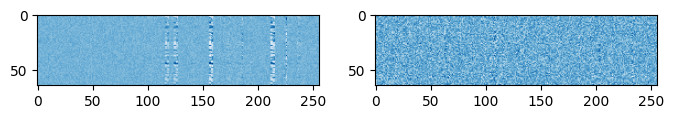

In [70]:
plt.figure(figsize=(8,4))

weight1=model.state_dict()['sdnet.conv.0.weight']
#print(weight[0].shape)
plt.subplot(1,2,1)
plt.imshow(weight1.reshape(64,-1),cmap="Blues")

weight2=model.state_dict()['sdnet.conv_trans.0.weight']
print(weight2.shape)
plt.subplot(1,2,2)
plt.imshow(weight2.reshape(64,-1),cmap="Blues")

#plt.savefig("conv_weight.svg",dpi=300)

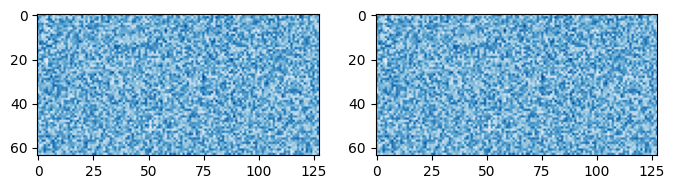

In [73]:
plt.figure(figsize=(8,4))
weight0=model.state_dict()['sdnet.conv.1.weight']
#print(weight[0].shape)
plt.subplot(1,2,1)
plt.imshow(weight0.reshape(64,-1),cmap="Blues")

weight1=model.state_dict()['sdnet.conv_trans.1.weight']
#print(weight[0].shape)
plt.subplot(1,2,2)
plt.imshow(weight0.reshape(64,-1),cmap="Blues")

In [54]:
y_hat,y_true=pred(model,test_loader)

In [57]:
mse,mae=Metrics(y_hat.reshape(-1,1),y_true.reshape(-1,1))

0.0045314375
0.050882597


In [55]:
pred=inverse_transform(y_hat)
true=inverse_transform(y_true)

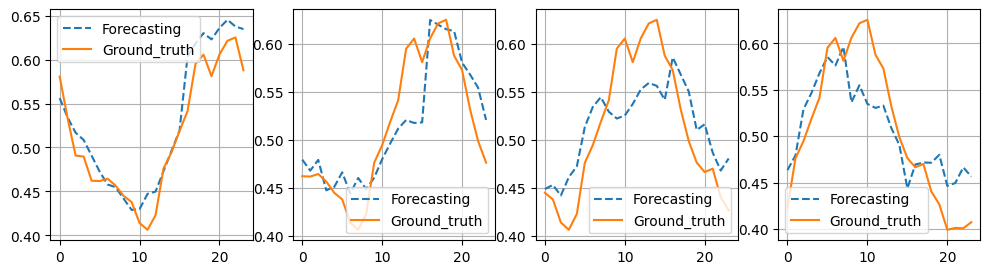

In [56]:
plt.figure(figsize=(12,3))
aa=111
window_size=24

plt.subplot(141)
plt.plot(pred[0],"--")
plt.plot(true[0])
plt.legend(["Forecasting","Ground_truth"])
plt.grid(1)

plt.subplot(142)
plt.plot(pred[4],"--")
plt.plot(true[4])
plt.legend(["Forecasting","Ground_truth"])
plt.grid(1)

plt.subplot(143)
plt.plot(pred[8],"--")
plt.plot(true[8])
plt.legend(["Forecasting","Ground_truth"])
plt.grid(1)

plt.subplot(144)
plt.plot(pred[12],"--")
plt.plot(true[12])
plt.legend(["Forecasting","Ground_truth"])
plt.grid(1)